In [1]:
#Notebook for the paper titled "Shallow Planning with Partial Observability"

# Install required packages
!pip install numpy matplotlib pymdptoolbox joblib

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import mdptoolbox
import time
from joblib import Parallel, delayed

# Setting construction and partial observability structural parameters results

In [2]:
class FixedMdp:
    """
    A class to represent a fixed Markov Decision Process (MDP).

    Attributes:
    -----------
    num_states : int
        Number of states in the MDP.
    num_actions : int
        Number of actions in the MDP.
    d : int
        Number of possible next states for each state-action pair.
    transitions : np.ndarray
        Transition probabilities for the MDP.
    rewards : np.ndarray
        Rewards for the MDP.

    Methods:
    --------
    generate_mdp():
        Generates the transition probabilities and rewards for an mdp of the type fixed. See the paper for details.
    """
    def __init__(self, num_states=10, d=3):
        self.num_states = num_states
        self.num_actions = 2
        self.d = d
        self.transitions = np.zeros((self.num_actions, num_states, num_states))
        self.rewards = np.zeros((num_states, self.num_actions))
        self.generate_mdp()

    def generate_mdp(self):
        for state in range(self.num_states):
            for action in range(self.num_actions):
                #Each state can be connected to d other states. We just fill non empty entries with transitions and rewards.
                probabilities = np.random.uniform(0, 1, self.d)
                probabilities /= probabilities.sum()
                next_states = np.random.choice(self.num_states, self.d, replace=False)
                self.rewards[state, action] = np.random.uniform(0, 1)
                self.transitions[action, state, next_states] = probabilities

def generate_mdps(num_mdps=1000, num_states=10, d=3):
    return [FixedMdp(num_states=num_states, d=d) for _ in range(num_mdps)]

In [3]:
class RingMdp:
    """
    A class to represent a ring-shaped Markov Decision Process (MDP).

    Attributes:
    -----------
    num_states : int
        Number of states in the MDP.
    p : float
        Probability of additional random connections.
    num_actions : int
        Number of actions in the MDP.
    transitions : np.ndarray
        Transition probabilities for the MDP.
    rewards : np.ndarray
        Rewards for the MDP.

    Methods:
    --------
    generate_mdp():
        Generates the transition probabilities and rewards for an mdp of type ring. See the paper for details.
    """
    def __init__(self, num_states=10, p=0):
        self.num_states = num_states
        self.p = p
        self.num_actions = 2
        self.transitions = np.zeros((2, num_states, num_states))
        self.rewards = np.zeros((num_states, 2))
        self.generate_mdp()

    def generate_mdp(self):
        for state in range(self.num_states):
            next_state_clockwise = (state + 1) % self.num_states
            prev_state_counterclockwise = (state - 1) % self.num_states
            
            # Action 1: Move clockwise or stay
            self.transitions[0, state, [next_state_clockwise, state]] = np.random.uniform(0, 1, 2)

            # Action 2: Move counterclockwise or stay
            self.transitions[1, state, [prev_state_counterclockwise, state]] = np.random.uniform(0, 1, 2)
            
            # Additional random connections based on probability p
            for other_state in range(self.num_states):
                if other_state != state and other_state != next_state_clockwise and np.random.rand() < self.p:
                    self.transitions[0, state, other_state] = np.random.uniform(0, 1)
                if other_state != state and other_state != prev_state_counterclockwise and np.random.rand() < self.p:
                    self.transitions[1, state, other_state] = np.random.uniform(0, 1)
            
            # Normalize again after adding random connections
            self.transitions[0, state, :] /= self.transitions[0, state, :].sum()
            self.transitions[1, state, :] /= self.transitions[1, state, :].sum()
            
            # Generate rewards
            self.rewards[state, 0] = np.random.uniform(0, 1)
            self.rewards[state, 1] = np.random.uniform(0, 1)

def generate_ring_mdps(num_mdps=1000, num_states=10, p=0):
    return [RingMdp(num_states, p) for _ in range(num_mdps)]

In [4]:
class POMDP:
    """
    Partially Observable Markov Decision Process (POMDP) class.

    Attributes
    ----------
    mdp : RingMdp
        The underlying Markov Decision Process (MDP).
    num_observations : int
        Number of possible observations.
    num_actions : int
        Number of possible actions.
    p_o_s : np.ndarray
        Observation probabilities given states.
    p_s_o : np.ndarray
        State probabilities given observations.
    transitions : np.ndarray
        Transition probabilities between observations.
    rewards : np.ndarray
        Rewards for each observation-action pair.

    Methods
    -------
    define_observation_prob():
        Defines the observation probabilities given states.
    define_p_s_o():
        Defines the state probabilities given observations.
    define_transitions():
        Defines the transition probabilities between observations.
    define_rewards():
        Defines the rewards for each observation-action pair.
    transition_function(current_state, action):
        Simulates a transition based on the MDP's transition probabilities.
    observation_function(next_state, action):
        Generates an observation based on the state's observation probability distribution.
    """
    def __init__(self, mdp, num_observations):
        """
        Initializes the POMDP with the given MDP and number of observations.

        Parameters
        ----------
        mdp : RingMdp
            The underlying Markov Decision Process (MDP).
        num_observations : int
            Number of possible observations.
        """
        self.mdp = mdp
        self.num_observations = num_observations
        self.num_actions = mdp.num_actions
        self.define_p_o_s()
        self.define_p_s_o()
        self.define_transitions()
        self.define_rewards()

    def define_p_o_s(self):
        """
        Defines the observation probabilities given states.
        """
        # Initialize P(O|S) for each state as a matrix of zeros
        self.p_o_s = np.zeros((self.mdp.num_states, self.num_observations))
        
        # Assign each state to an observation ensuring every observation has at least one state
        for state in range(self.mdp.num_states):
            self.p_o_s[state, state % self.num_observations] = 1

    def define_p_s_o(self):
        """
        Defines the state probabilities given observations.
        """
        # Initialize P(S|O) for each observation as a matrix of zeros
        self.p_s_o = np.zeros((self.num_observations, self.mdp.num_states))
        # Here for each observation we just define a uniform distribution on the corresponding ground states
        for obs in range(self.num_observations):
            ground_states = np.where(self.p_o_s[:, obs] == 1)[0]
            num_ground_states = len(ground_states)
            self.p_s_o[obs, :] = 0  # Set all probabilities to zero
            self.p_s_o[obs, ground_states] = 1 / num_ground_states  # Set uniform probability for relevant ground states
        
    def define_transitions(self):
        """
        Defines the transition probabilities between observations.
        """
        self.transitions = np.zeros((self.num_actions, self.num_observations, self.num_observations))

        for action in range(self.num_actions):
            for observation in range(self.num_observations):
                for next_observation in range(self.num_observations):
                    self.transitions[action, observation, next_observation] = np.sum([np.dot(self.p_s_o[observation, :], self.mdp.transitions[action, :, next_state]) for next_state in range(self.mdp.num_states) if self.p_s_o[next_observation, next_state] > 0])

    def define_rewards(self):
        """
        Defines the rewards for each observation-action pair.
        """
        self.rewards = np.einsum('os,sa->oa', self.p_s_o, self.mdp.rewards)

    def transition_function(self, current_state, action):
        """
        Simulates a transition based on the MDP's transition probabilities.

        Parameters
        ----------
        current_state : int
            The current state in the MDP.
        action : int
            The action taken.

        Returns
        -------
        int
            The next state in the MDP.
        """
        return np.random.choice(self.mdp.num_states, p=self.mdp.transitions[action, current_state])

In [5]:
# This cell sets up all the POMDPs (Partially Observable Markov Decision Processes) for the simulations.
# It first generates a list of MDPs (Markov Decision Processes) using the generate_mdps function (use fixed or ring).
mdps = generate_mdps(10, 10, 3)

# Define a list of omega values which will be used to create POMDPs with varying cardinality of the observation space (hence the name Omega).
omega_values = [10, 8, 6, 4, 2, 1]

# Initialize a 2D list to store all the POMDPs. The outer list corresponds to each MDP,
# and the inner list corresponds to each omega value for that MDP.
all_pomdps = [[None for _ in omega_values] for _ in mdps]

# Iterate over each MDP and each omega value to create the corresponding POMDP.
for mdp_idx, mdp in enumerate(mdps):
    for p_idx, p in enumerate(omega_values):
        pomdp = POMDP(mdp, p)
        all_pomdps[mdp_idx][p_idx] = pomdp

In [6]:
#This cell calculates the action variation for each POMDPs and each underlying mdps.

delta_M_o = np.zeros((len(all_pomdps), len(omega_values)))
for pomdp_idx, pomdp_instance in enumerate(all_pomdps):
    for p_idx, p in enumerate(omega_values):
        for o in range(pomdp_instance[p_idx].num_observations):
            if np.sum(np.abs(pomdp_instance[p_idx].transitions[0,o,:] - pomdp_instance[p_idx].transitions[1,o,:])) > delta_M_o[pomdp_idx, p_idx]:
                delta_M_o[pomdp_idx, p_idx] = np.sum(np.abs(pomdp_instance[p_idx].transitions[0,o,:] - pomdp_instance[p_idx].transitions[1,o,:]))

delta_M_s = np.zeros((len(all_pomdps)))
for pomdp_idx, pomdp_instance in enumerate(all_pomdps):
    for s in range(pomdp_instance[0].mdp.num_states):
        if np.sum(np.abs(pomdp_instance[0].mdp.transitions[0,s,:] - pomdp_instance[0].mdp.transitions[1,s,:])) > delta_M_s[pomdp_idx]:
            delta_M_s[pomdp_idx] = np.sum(np.abs(pomdp_instance[0].mdp.transitions[0,s,:] - pomdp_instance[0].mdp.transitions[1,s,:]))

In [7]:
#normalize by dividing the parameter on each POMDP by the one on the state space.
normalized_delta_M_o = np.zeros((len(all_pomdps), len(omega_values)))
for pomdp_idx, pomdp_instance in enumerate(all_pomdps):
    for p_idx, p in enumerate(omega_values):
        normalized_delta_M_o[pomdp_idx, p_idx] = delta_M_o[pomdp_idx, p_idx] / delta_M_s[pomdp_idx]

In [8]:
#This cell calculates the value-function variation for each POMDPs and their underlying MDPs.
gammas = np.linspace(0.0001,0.99,3)

state_values = np.zeros((len(gammas),len(all_pomdps), all_pomdps[0][0].mdp.num_states))
#kappa_s
kappa_gamma_s = np.zeros((len(gammas), len(all_pomdps)))
for gamma_idx, gamma in enumerate(gammas):
    for pomdp_idx, pomdp_instance in enumerate(all_pomdps):
        pi = mdptoolbox.mdp.PolicyIteration(pomdp_instance[0].mdp.transitions, pomdp_instance[0].mdp.rewards,discount=gamma)
        pi.run()
        kappa_gamma_s[gamma_idx, pomdp_idx] = max(pi.V) - min(pi.V)
        state_values[gamma_idx, pomdp_idx, :] = pi.V


kappa_gamma_phi = np.zeros((len(gammas), len(all_pomdps), len(omega_values)))
#for each pomdps find the optimal values for each p
for gamma_idx, gamma in enumerate(gammas):
    for pomdp_idx, pomdp_instance in enumerate(all_pomdps):
        for p_idx, p in enumerate(omega_values):
            pi = mdptoolbox.mdp.PolicyIteration(pomdp_instance[p_idx].transitions, pomdp_instance[p_idx].rewards,discount=gamma)
            pi.run()
            kappa_gamma_phi[gamma_idx, pomdp_idx, p_idx] = max(pi.V) - min(pi.V)

In [9]:
#This cell calculates the bias for every POMDPs for varying values of gamma.

#You can set up the precision by changing the number of points in the linspace as long as the discount factor is between ]0,1[.
gammas_biases = np.linspace(0.0001,0.99,100)

bias = np.zeros((len(gammas_biases), len(all_pomdps), len(omega_values)))

# Now calculate the relative losses
for p_idx, p in enumerate(omega_values):
    for pomdp_idx, pomdp_instance in enumerate(all_pomdps):
        for gamma_idx, gamma in enumerate(gammas_biases):
            if gamma_idx == 0:
                pi = mdptoolbox.mdp.PolicyIteration(pomdp_instance[p_idx].transitions, pomdp_instance[p_idx].rewards, discount=gammas_biases[-1])
                pi.run()
                Max_values = pi.V
            pi = mdptoolbox.mdp.PolicyIteration(pomdp_instance[p_idx].transitions, pomdp_instance[p_idx].rewards, discount=gamma)
            pi.run()
            policy_array = np.array(pi.policy)
            R_pi = pomdp_instance[p_idx].rewards[np.arange(pomdp_instance[p_idx].num_observations), policy_array]
            P_pi = pomdp_instance[p_idx].transitions[policy_array, np.arange(pomdp_instance[p_idx].num_observations), :]
            V_pi_lowgamm = np.linalg.inv(np.eye(pomdp_instance[p_idx].num_observations) - gammas_biases[-1] * P_pi) @ R_pi
            bias[gamma_idx, pomdp_idx, p_idx] = np.max((Max_values - V_pi_lowgamm) / Max_values)



In [10]:
#Normalize the value-function variation for each POMDPs by the value of the parameter on the underlying MDP.
normalized_kappa_gamma = np.zeros((len(gammas), len(all_pomdps), len(omega_values)))
for gamma_idx, gamma in enumerate(gammas):
    for pomdp_idx, pomdp_instance in enumerate(all_pomdps):
        for p_idx, p in enumerate(omega_values):
            normalized_kappa_gamma[gamma_idx, pomdp_idx, p_idx] = kappa_gamma_phi[gamma_idx, pomdp_idx, p_idx] / kappa_gamma_s[gamma_idx, pomdp_idx]


In [11]:
# This cell calculates the Blackwell optimal discount factor gamma for each POMDP and omega value.
# See the paper for a detailed explanation of the algorithm.
gammas_for_bw = np.linspace(0.99, 0.0001, 100)  

blackwell_gammas = np.zeros((len(all_pomdps), len(omega_values)))

def process_pomdp(pomdp_instance, p_idx, p, gammas):
    last_policy = None
    for gamma_idx, gamma in enumerate(gammas_for_bw):
        pi = mdptoolbox.mdp.PolicyIteration(pomdp_instance[p_idx].transitions, pomdp_instance[p_idx].rewards, discount=gamma)
        pi.run()
        if last_policy is not None and not np.array_equal(pi.policy, last_policy):
            break
        last_policy = pi.policy
        gamma_value = gamma
    return gamma_value

#We use Joblib to paralellize this process since it can be very slow and every POMDPs are independant.
results = Parallel(n_jobs=-1)(delayed(process_pomdp)(pomdp_instance, p_idx, p, gammas) for pomdp_idx, pomdp_instance in enumerate(all_pomdps) for p_idx, p in enumerate(omega_values))

#Bringing the results in the right data structure.
for idx, result in enumerate(results):
    pomdp_idx = idx // len(omega_values)
    p_idx = idx % len(omega_values)
    blackwell_gammas[pomdp_idx, p_idx] = result

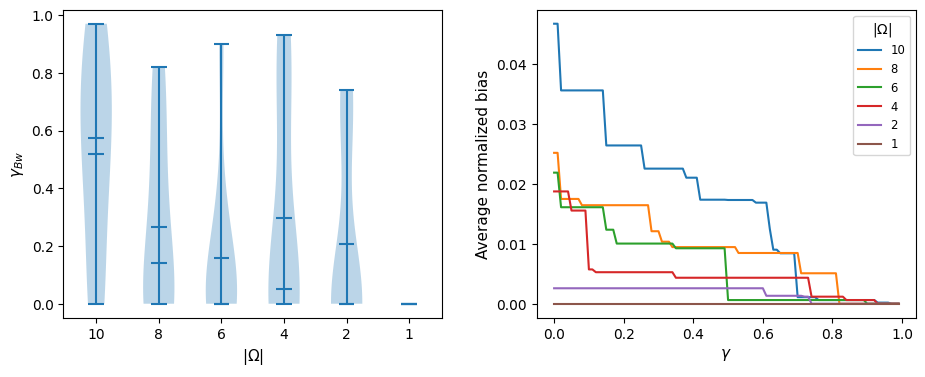

In [12]:
#This cell plots the data for the blackwell discount factor and the bias which varies as a function of Omega

fig, axs = plt.subplots(1, 2, figsize=(11, 4), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.25})  # Create a figure with 1 row and 2 columns, increased figure width and added space between plots

# Common settings for all plots
plot_settings = {
    'showmeans': True,
    'showextrema': True,
    'showmedians': True
}

#Plotting the blackwell discount factor
axs[0].violinplot(blackwell_gammas, positions=range(len(omega_values)), showmeans=True, showextrema=True, showmedians=True)
axs[0].set_xticks(range(len(omega_values)))
axs[0].set_xticklabels(omega_values)
axs[0].set_ylabel('$\gamma_{Bw}$', fontsize=11)
axs[0].set_xlabel('$|\Omega|$', fontsize=11)


#Plotting the bias
for p_idx, p in enumerate(omega_values):
    axs[1].plot(gammas_biases, bias[:, :, p_idx].mean(axis=1), label=p)
axs[1].set_ylabel('Average normalized bias', fontsize=11)
axs[1].legend(title="$|\Omega|$", fontsize='small')  
axs[1].set_xlabel('$\gamma$', fontsize=11)


# Save the figure as a PDF file
plt.savefig("Combined_Plots_bias.pdf", format='pdf')
plt.show()
plt.close()


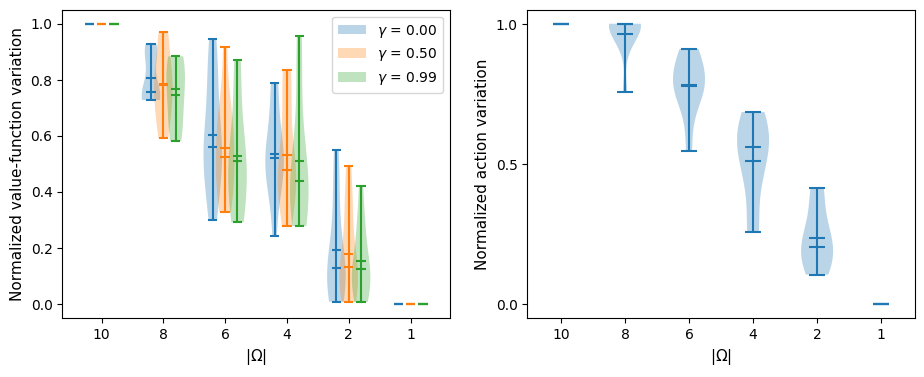

In [13]:
# This cell generates the plots for the normalized value-function variation and the normalized action variation for different values of
# Omega.

fig, axs = plt.subplots(1, 2, figsize=(11, 4))  # Create a figure with 1 row and 2 columns

#We start by plotting the normalized value-function variation for different values of Omega.
violin_parts = []
offset_increment = 0.2

for i, gamma in enumerate(gammas):
    positions = [p + i * offset_increment for p in range(len(omega_values))]  
    vp = axs[0].violinplot(normalized_kappa_gamma[i], positions=positions, **plot_settings, widths=0.3)  
    violin_parts.append(vp)

axs[0].set_xticks([p + (len(gammas) - 1) * 0.2 / 2 for p in range(len(omega_values))])  
axs[0].set_xticklabels(omega_values)
axs[0].set_ylabel('Normalized value-function variation', fontsize=11)
axs[0].set_xlabel('$|\Omega|$', fontsize=11)
labels = [f'$\gamma$ = {gamma:.2f}' for gamma in gammas]
axs[0].legend([vp["bodies"][0] for vp in violin_parts], labels, loc='upper right', fontsize=10)


#Next we plot the normalized action variation for different values of Omega.
axs[1].violinplot(normalized_delta_M_o, positions=range(len(omega_values)), **plot_settings)
axs[1].set_xticks(range(len(omega_values)))
axs[1].set_xticklabels(omega_values)
axs[1].set_ylabel('Normalized action variation', fontsize=11)
axs[1].set_yticks(np.arange(0, 1.1, 0.5))
axs[1].set_xlabel('$|\Omega|$', fontsize=11)

plt.savefig("Combined_Plots_params.pdf", format='pdf')
plt.show()
plt.close()


# Tightness of theorem 1

In [14]:
#For this section, we will use the fixed MDP but this can be easily adapted to ring MDP or any other MDP.

#We assume the rewards are known for our certainty equivalence setting similar to (The Dependence of Effective Planning Horizon on Model Accuracy Jiang et al 2015)
#We compute approximate transitions from n_sample and deduce the optimal policy to compare the bound.

class EstimatedMDP:
    def __init__(self, transitions, rewards, num_states, d):
        self.transitions = transitions
        self.rewards = rewards
        self.num_states = num_states
        self.d = d
        self.num_actions = 2  # Assuming a fixed number of actions as in the FixedMdp class


def estimate_single_mdp(mdp, n_samples):
    """
    Estimate the transition probabilities of a single MDP using sample transitions.

    Parameters:
    mdp (MDP): The Markov Decision Process to estimate.
    n_samples (int): The number of samples to use for estimating the transitions.

    Returns:
    EstimatedMDP: A new MDP with estimated transition probabilities.
    """
    num_states = mdp.num_states
    num_actions = mdp.num_actions
    estimated_transitions = np.zeros((num_actions, num_states, num_states))
    
    for state in range(num_states):
        for action in range(num_actions):
            next_states = np.random.choice(num_states, size=n_samples, p=mdp.transitions[action, state, :])
            
            for next_state in range(num_states):
                estimated_transitions[action, state, next_state] = np.sum(next_states == next_state) / n_samples

    return EstimatedMDP(estimated_transitions, mdp.rewards, num_states, num_actions)

#This function exists for paralellization purposes
def estimate_mdps(mdps, n_samples):
    estimated_mdps = Parallel(n_jobs=-1)(delayed(estimate_single_mdp)(mdp, n_samples) for mdp in mdps)
    return estimated_mdps

In [24]:
def calculate_delta_M(mdp, discordant_states):
    """
    Calculate delta_M over discordant states. 

    Parameters:
    mdp (MDP): The Markov Decision Process.
    state_vector (np.array): A vector of 1s and 0s indicating the states to consider.

    Returns:
    np.array: An array of delta_M values for the states indicated by the state_vector.
    """
    num_states = mdp.num_states
    num_actions = mdp.num_actions
    delta_M = 0

    for state in range(num_states):
        if discordant_states[state] == 1:
            if np.sum(np.abs(mdp.transitions[0, state, :] - mdp.transitions[1, state, :])) > delta_M:
                delta_M = np.sum(np.abs(mdp.transitions[0, state, :] - mdp.transitions[1, state, :]))

    return delta_M

def bias_ad_hoc_function(delta_M, blackwell_gamma):
    """
    Calculate an important quantity that appears in the condition of tightness.

    Parameters:
    delta_M (float): The delta_M value representing the maximum l1 distance between transition probabilities (action-variation).
    blackwell_gamma (float): The Blackwell optimal discount factor gamma.

    Returns:
    float: The calculated bias value.
    """
    return (delta_M / 2) / (1 - blackwell_gamma * (1 - delta_M / 2))



In [16]:
#This is the main cell which dictates parameters for the simulations for evaluating the tightness of theorem 1.

# It first generates a list of MDPs (Markov Decision Processes) using the generate_mdps function (use fixed or ring).
mdps = generate_mdps(100, 10, 3)

#The number of samples for each state-action pair tested
n_samples_list = [1, 5, 25, 50]

#The gammas for which the bound is computed, precision can be changed as long as the discount factor is between ]0,1[.
gammas = np.linspace(0.0001,0.99,20)

all_estimated_mdps = []

for i, n_samples in enumerate(n_samples_list):
    estimated_mdps = estimate_mdps(mdps, n_samples)
    all_estimated_mdps.append(estimated_mdps)


In [17]:
# This cell calculates the Blackwell optimal discount factor gamma for each MDP.
# See the paper for a detailed explanation of the algorithm.
gammas_for_bw = np.linspace(0.99, 0.0001, 100)  

blackwell_gammas = np.zeros(len(mdps))

def process_mdp(mdp_instance, gammas):
    last_policy = None
    for gamma_idx, gamma in enumerate(gammas_for_bw):
        pi = mdptoolbox.mdp.PolicyIteration(mdp_instance.transitions, mdp_instance.rewards, discount=gamma)
        pi.run()
        if last_policy is not None and not np.array_equal(pi.policy, last_policy):
            break
        last_policy = pi.policy
        gamma_value = gamma
    return gamma_value

# We use Joblib to parallelize this process since it can be very slow and every MDP is independent.
results = Parallel(n_jobs=-1)(delayed(process_mdp)(mdp_instance, gammas) for mdp_instance in mdps)

# Bringing the results in the right data structure.
for idx, result in enumerate(results):
    blackwell_gammas[idx] = result

In [23]:
#This cell calculates if the condition is true for every mdps, number of sample and gammas.
#We therefore start by declaring every parameter that goes in the condition
kappa_gamma_true = np.zeros((len(gammas), len(mdps)))
rmax = np.zeros((len(gammas), len(mdps)))
epsilon = np.zeros((len(gammas),len(n_samples_list), len(mdps)))
discordant_estimation = np.zeros((len(gammas),len(n_samples_list), len(mdps),mdps[0].num_states))
discordant_horizon = np.zeros((len(gammas), len(mdps),mdps[0].num_states))
kappa_gamma = np.zeros((len(gammas), len(mdps)))
delta_M_gamma = np.zeros((len(gammas), len(mdps)))
delta_M_gamma_hat = np.zeros((len(gammas), len(n_samples_list),len(mdps)))

condition_reached = np.zeros((len(gammas), len(n_samples_list), len(mdps)))


#We start by retrieving the optimal policy on the horizon
policy_bw = []
for mdp_idx, mdp in enumerate(mdps):
    pi = mdptoolbox.mdp.PolicyIteration(mdp.transitions, mdp.rewards,discount=gammas[-1])
    pi.run()
    policy_bw.append(pi.policy)


# This is the main loop. It iterates over each discount factor (gamma) and each MDP instance.
# For each combination, it calculates various metrics such as kappa_gamma, rmax, discordant_horizon, and delta_M_gamma.
# It then estimates the policy for different sample sizes and calculates the epsilon and discordant_estimation.
# Finally, it checks the condition of tightness is met (see the paper for details)

for gamma_idx, gamma in enumerate(gammas):
    for mdp_idx, mdp in enumerate(mdps):
        #Here we get the values for the true mdp with no estimation and we extract the policy
        pi_true = mdptoolbox.mdp.PolicyIteration(mdp.transitions, mdp.rewards,discount=gamma)
        pi_true.run()
        true_policy_array = np.array(pi_true.policy)

        kappa_gamma[gamma_idx, mdp_idx] = max(pi_true.V) - min(pi_true.V)
        rmax[gamma_idx, mdp_idx] = np.max(mdp.rewards)
        discordant_horizon[gamma_idx, mdp_idx, :] = (policy_bw[mdp_idx] != true_policy_array).astype(int)

        delta_M_gamma[gamma_idx, mdp_idx] = calculate_delta_M(mdp, discordant_horizon[gamma_idx, mdp_idx, :])


        for n_idx, n_samples in enumerate(n_samples_list):
            
            #Here we check for every estimated mdps. We start by retrieving the policy and then we extract the parameters
            pi_estimated = mdptoolbox.mdp.PolicyIteration(all_estimated_mdps[n_idx][mdp_idx].transitions, all_estimated_mdps[n_idx][mdp_idx].rewards,discount=gamma)
            pi_estimated.run()
            estimated_policy_array = np.array(pi_estimated.policy)

            #Get epsilon
            R_pi_estimated = mdp.rewards[np.arange(mdp.num_states), estimated_policy_array]
            P_pi_estimated = mdp.transitions[estimated_policy_array, np.arange(mdp.num_states), :]

            R_pi_true = mdp.rewards[np.arange(mdp.num_states), true_policy_array]
            P_pi_true = mdp.transitions[true_policy_array, np.arange(mdp.num_states), :]


            V_pi_estimated = np.linalg.inv(np.eye(mdp.num_states) - gamma * P_pi_estimated) @ R_pi_estimated
            V_pi_true = np.linalg.inv(np.eye(mdp.num_states) - gamma * P_pi_true) @ R_pi_true

            epsilon[gamma_idx, n_idx, mdp_idx] = np.max(np.abs(V_pi_estimated - V_pi_true))

            #Get discordant estimation
            #For each states, flag a 1 if policies are unequal
            discordant_estimation[gamma_idx, n_idx, mdp_idx, :] = (true_policy_array != estimated_policy_array).astype(int)

            delta_M_gamma_hat[gamma_idx, n_idx, mdp_idx] = calculate_delta_M(mdp, discordant_estimation[gamma_idx, n_idx, mdp_idx, :])

            condition_reached[gamma_idx, n_idx, mdp_idx] = (
                epsilon[gamma_idx, n_idx, mdp_idx] <= 
                rmax[gamma_idx, mdp_idx] / (1 - gamma) - 
                kappa_gamma[gamma_idx, mdp_idx] * 
                (bias_ad_hoc_function(delta_M_gamma_hat[gamma_idx, n_idx, mdp_idx], blackwell_gammas[mdp_idx]) + 
                bias_ad_hoc_function(delta_M_gamma[gamma_idx, mdp_idx], blackwell_gammas[mdp_idx]))
            )
                        

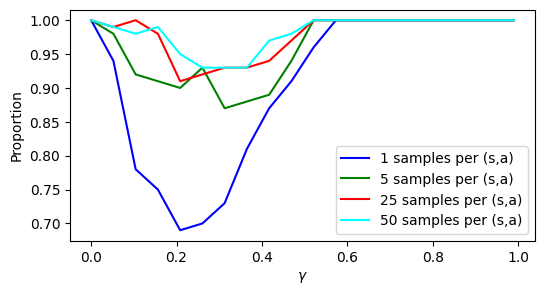

In [22]:
import matplotlib.pyplot as plt

# Plot the proportion of time for each gamma where condition_reached is True for each MDP
plt.figure(figsize=(6, 3)) 
colors = ['blue', 'green', 'red', 'cyan']
for i, n_samples in enumerate(n_samples_list):
    proportions = np.zeros(len(gammas))
    for gamma_index, gamma in enumerate(gammas):
        proportions[gamma_index] = np.sum(condition_reached[gamma_index, i, :]) / condition_reached.shape[2]
    plt.plot(gammas, proportions, linestyle='-', color=colors[i], label=f'{n_samples} samples per (s,a)')

plt.xlabel(r'$\gamma$')
plt.ylabel('Proportion')
plt.legend()

# Save the plot as a vector image (PDF) with a larger size
plt.savefig("gamma_proportions.pdf", format='pdf', bbox_inches='tight')  
plt.show()
plt.close()
